In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df
from taiko.performance import get_performance, get_pf_similarity

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 4

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
4,aaaaa,4,L_2018-09-28_112353.csv,R_2018-09-28_112355.csv,capture_2018_09_28_11_23_55
8,aaaaa,4,L_2018-09-28_113909.csv,R_2018-09-28_113910.csv,capture_2018_09_28_11_39_10
12,aaaaa,4,L_2018-09-28_115428.csv,R_2018-09-28_115429.csv,capture_2018_09_28_11_54_30
16,aaaaa,4,L_2018-09-28_120635.csv,R_2018-09-28_120636.csv,capture_2018_09_28_12_06_36
28,carolyn,4,L_2018-09-27_160108.csv,R_2018-09-27_160109.csv,capture_2018_09_27_16_01_08
32,carolyn,4,L_2018-09-27_161429.csv,R_2018-09-27_161430.csv,capture_2018_09_27_16_14_30
36,carolyn,4,L_2018-09-27_162708.csv,R_2018-09-27_162709.csv,capture_2018_09_27_16_27_09
40,carolyn,4,L_2018-09-27_163944.csv,R_2018-09-27_163945.csv,capture_2018_09_27_16_39_45
58,celiven,4,L_2018-09-22_165755.csv,R_2018-09-22_165755.csv,capture_2018_09_22_16_57_54
63,chris,4,L_2018-09-26_133921.csv,R_2018-09-26_133922.csv,capture_2018_09_26_13_39_21


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
3,aaaaa,4,L_2018-09-28_112353.csv,R_2018-09-28_112355.csv,capture_2018_09_28_11_23_55,4,1,889790,215,71,0,286,301
7,aaaaa,4,L_2018-09-28_113909.csv,R_2018-09-28_113910.csv,capture_2018_09_28_11_39_10,8,2,886690,217,68,1,270,275
11,aaaaa,4,L_2018-09-28_115428.csv,R_2018-09-28_115429.csv,capture_2018_09_28_11_54_30,12,3,920320,234,52,0,286,316
15,aaaaa,4,L_2018-09-28_120635.csv,R_2018-09-28_120636.csv,capture_2018_09_28_12_06_36,16,4,923760,238,48,0,286,325
19,carolyn,4,L_2018-09-27_160108.csv,R_2018-09-27_160109.csv,capture_2018_09_27_16_01_08,28,1,548460,92,128,66,34,186
23,carolyn,4,L_2018-09-27_161429.csv,R_2018-09-27_161430.csv,capture_2018_09_27_16_14_30,32,2,620240,122,99,65,49,203
27,carolyn,4,L_2018-09-27_162708.csv,R_2018-09-27_162709.csv,capture_2018_09_27_16_27_09,36,3,646130,125,107,54,66,214
31,carolyn,4,L_2018-09-27_163944.csv,R_2018-09-27_163945.csv,capture_2018_09_27_16_39_45,40,4,759490,155,120,11,109,202
44,celiven,4,L_2018-09-22_165755.csv,R_2018-09-22_165755.csv,capture_2018_09_22_16_57_54,58,1,870560,208,78,0,286,254
48,chris,4,L_2018-09-26_133921.csv,R_2018-09-26_133922.csv,capture_2018_09_26_13_39_21,63,1,743250,151,116,19,97,209


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
3,aaaaa,4,L_2018-09-28_112353.csv,R_2018-09-28_112355.csv,capture_2018_09_28_11_23_55,4,1,889790,215,71,0,286,301
11,aaaaa,4,L_2018-09-28_115428.csv,R_2018-09-28_115429.csv,capture_2018_09_28_11_54_30,12,3,920320,234,52,0,286,316
15,aaaaa,4,L_2018-09-28_120635.csv,R_2018-09-28_120636.csv,capture_2018_09_28_12_06_36,16,4,923760,238,48,0,286,325
44,celiven,4,L_2018-09-22_165755.csv,R_2018-09-22_165755.csv,capture_2018_09_22_16_57_54,58,1,870560,208,78,0,286,254
68,chris,4,L_2018-10-01_195718.csv,R_2018-10-01_195719.csv,capture_2018_10_01_19_57_17,84,6,893290,224,62,0,286,214
76,chris,4,L_2018-10-01_201852.csv,R_2018-10-01_201853.csv,capture_2018_10_01_20_18_52,92,8,908590,235,51,0,286,216
177,howeverover,4,L_2018-09-29_193217.csv,R_2018-09-29_193219.csv,capture_2018_09_29_19_32_19,205,5,839250,184,102,0,286,273
181,howeverover,4,L_2018-09-29_194539.csv,R_2018-09-29_194539.csv,capture_2018_09_29_19_45_40,209,6,857420,197,89,0,286,289
185,howeverover,4,L_2018-09-29_195819.csv,R_2018-09-29_195820.csv,capture_2018_09_29_19_58_21,213,7,888090,214,72,0,286,286
315,sheep,4,L_2018-09-29_142641.csv,R_2018-09-29_142641.csv,capture_2018_09_29_14_26_42,351,8,876480,230,56,0,286,230


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
# CONSIDERED_IDS = [1, 33, 60, 98, 149, 179, 240, 248, 287, 322]

# doraemon individual for two occurance
# CONSIDERED_IDS = [1, 5, 33, 37, 60, 64, 98, 106, 149, 153, 179, 180, 240, 248, 253, 257, 287, 309, 322, 326]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 78, 82, 120, 124, 154, 158, 207, 215, 279, 283, 310, 314, 349, 353]

# sakura individual for two occurance
# CONSIDERED_IDS = [11, 15, 53, 57, 79, 83, 104, 108, 208, 212, 280, 284, 319, 350, 354]

# ice individual for two occurance
CONSIDERED_IDS = [12, 16, 58, 84, 92, 209, 213, 351, 355]

# all
# CONSIDERED_IDS = play_record_df['id'].values

# full_combo
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

[12, 16, 58, 84, 92, 209, 213, 351, 355]

In [8]:
plays = []
with multiprocessing.Pool() as p:
    for _, play in tqdm(enumerate(p.imap(get_play, CONSIDERED_IDS)), total=len(CONSIDERED_IDS)):
        plays.append(play)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 79/79 [00:00<00:00, 151.73it/s]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,64
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,65


In [8]:
pfs = []
for i_, id_ in tqdm(enumerate(CONSIDERED_IDS), total=len(CONSIDERED_IDS)):
    pid = id_
    pf = get_performance(pid)
    pfs.append(pf)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 20/20 [00:00<00:00, 48.87it/s]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
45,chris,1,L_2018-09-26_133059.csv,R_2018-09-26_133100.csv,capture_2018_09_26_13_30_59,60,1,908230,76,10,0,86,44
49,chris,1,L_2018-09-26_134302.csv,R_2018-09-26_134304.csv,capture_2018_09_26_13_43_03,64,2,987660,85,1,0,86,50
81,cuxi,1,L_2018-09-25_160510.csv,R_2018-09-25_160512.csv,capture_2018_09_25_16_05_13,98,2,942410,77,9,0,86,63
89,cuxi,1,L_2018-09-25_163116.csv,R_2018-09-25_163117.csv,capture_2018_09_25_16_31_18,106,4,974110,81,5,0,86,67
121,eve,1,L_2018-09-26_175516.csv,R_2018-09-26_175517.csv,capture_2018_09_26_17_55_17,140,4,892060,67,19,0,86,39
129,eve,1,L_2018-09-28_163325.csv,R_2018-09-28_163326.csv,capture_2018_09_28_16_33_26,149,6,928410,75,11,0,86,38


In [8]:
plays = []
with multiprocessing.Pool() as p:
    for _, play in tqdm(enumerate(p.imap(get_play, CONSIDERED_IDS)), total=len(CONSIDERED_IDS)):
        plays.append(play)

play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 9/9 [00:00<00:00, 72.19it/s]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
11,aaaaa,4,L_2018-09-28_115428.csv,R_2018-09-28_115429.csv,capture_2018_09_28_11_54_30,12,3,920320,234,52,0,286,316
15,aaaaa,4,L_2018-09-28_120635.csv,R_2018-09-28_120636.csv,capture_2018_09_28_12_06_36,16,4,923760,238,48,0,286,325
44,celiven,4,L_2018-09-22_165755.csv,R_2018-09-22_165755.csv,capture_2018_09_22_16_57_54,58,1,870560,208,78,0,286,254
68,chris,4,L_2018-10-01_195718.csv,R_2018-10-01_195719.csv,capture_2018_10_01_19_57_17,84,6,893290,224,62,0,286,214
76,chris,4,L_2018-10-01_201852.csv,R_2018-10-01_201853.csv,capture_2018_10_01_20_18_52,92,8,908590,235,51,0,286,216
181,howeverover,4,L_2018-09-29_194539.csv,R_2018-09-29_194539.csv,capture_2018_09_29_19_45_40,209,6,857420,197,89,0,286,289
185,howeverover,4,L_2018-09-29_195819.csv,R_2018-09-29_195820.csv,capture_2018_09_29_19_58_21,213,7,888090,214,72,0,286,286
315,sheep,4,L_2018-09-29_142641.csv,R_2018-09-29_142641.csv,capture_2018_09_29_14_26_42,351,8,876480,230,56,0,286,230
319,sheep,4,L_2018-09-29_144052.csv,R_2018-09-29_144053.csv,capture_2018_09_29_14_40_54,355,9,876980,212,74,0,286,231


In [9]:
HANDS = ['L', 'R']
_K = 370
# SIMILARITY_COLUMNS = [a + '_' + b for a, b in product(HANDS, ZERO_ADJ_COL)]
# SIMILARITY_COLUMNS = list(pfs[0].columns)[1:]
SIMILARITY_COLUMNS = ['acc_dtw', 'gyr_dtw']
# SIMILARITY_COLUMNS = [str(k) + '_' + b for k, b in product(range(_K), SIMILARITY_COLUMNS)]
# SIMILARITY_COLUMNS = [a + '_' + b for a, b in product(HANDS, SIMILARITY_COLUMNS)]
SIMILARITY_COLUMNS

['acc_dtw', 'gyr_dtw']

In [10]:
similarity_mat = []
with multiprocessing.Pool() as p:
    result = p.starmap(get_similarity, product(plays, repeat=2))
    ids = list(product(CONSIDERED_IDS, repeat=2))
    for ids_, sim in zip(ids, result):
        similarity_mat.append(list(ids_) + list(sim))
#         sim = get_similarity(row1[1], row2[1])
#         similarity_mat.append([row1[0], row2[0], sim[0], sim[1]])
#         print(sim)

similarity_df = pd.DataFrame(data=similarity_mat)
similarity_df.columns = ['a_id', 'b_id'] + SIMILARITY_COLUMNS
similarity_df

,a_id,b_id,acc_dtw,gyr_dtw
0,12,12,0.000000,0.000000
1,12,16,11537.762248,4591.639915
2,12,58,13267.897603,10739.552710
3,12,84,10790.082018,8383.252403
4,12,92,9664.183961,7626.986864
5,12,209,11552.010445,11148.293295
6,12,213,11122.053857,9319.120950
7,12,351,11423.932427,11654.505966
8,12,355,11486.110314,12083.931882
9,16,12,11334.279811,4670.575656


/usr/bin/anaconda3/envs/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


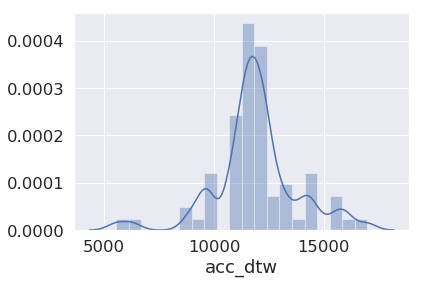

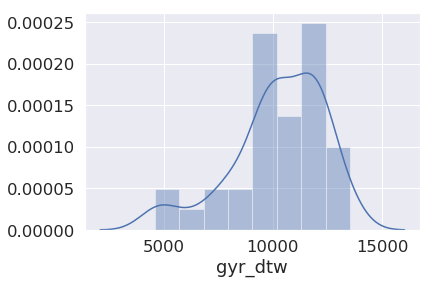

In [11]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)
for col in SIMILARITY_COLUMNS:
    sns.distplot(dtw_df[col])
    plt.show()
dtw_df.to_csv('dtw_df@cosine_4.csv', index=False)

In [12]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
1,12,16,-0.188547,-2.667495,-1.428021
2,12,58,0.721693,0.230357,0.476025
3,12,84,-0.581908,-0.880298,-0.731103
4,12,92,-1.174253,-1.236768,-1.205510
5,12,209,-0.181051,0.423019,0.120984
6,12,213,-0.407255,-0.439171,-0.423213
7,12,351,-0.248434,0.661625,0.206596
8,12,355,-0.215721,0.864038,0.324158
9,16,12,-0.295601,-2.630289,-1.462945
11,16,58,-0.165594,0.072308,-0.046643


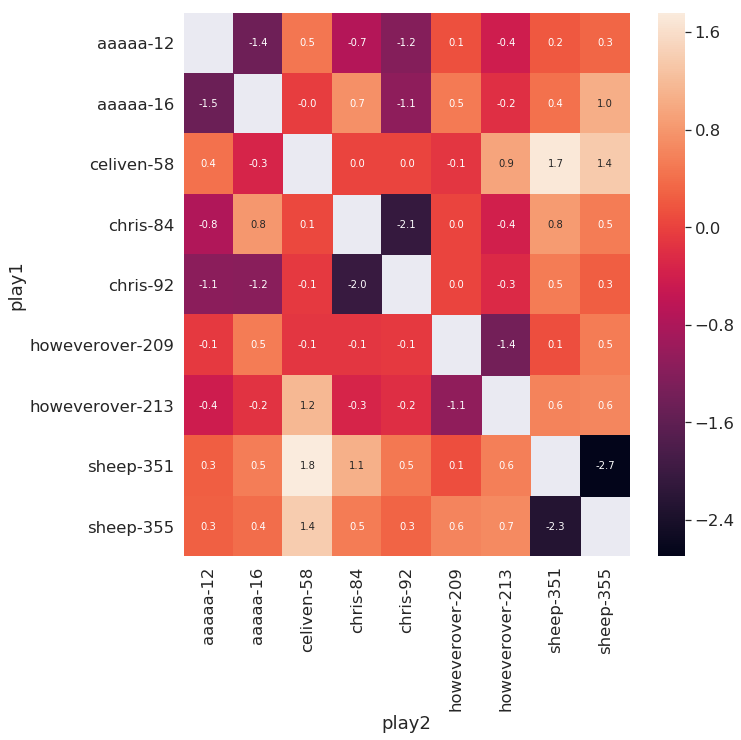

In [13]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(10, 10))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

In [14]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)

scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
for col in SIMILARITY_COLUMNS:
    dtw_df[col] -= dtw_df.min(axis=0)[col]
    
dtw_df['norm_sim'] = np.sqrt(np.square(dtw_df[SIMILARITY_COLUMNS]).sum(axis=1))
dtw_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim
1,12,16,3.147988,0.000000,3.147988
2,12,58,4.058228,2.897852,4.986658
3,12,84,2.754627,1.787197,3.283602
4,12,92,2.162282,1.430727,2.592768
5,12,209,3.155484,3.090515,4.416827
6,12,213,2.929280,2.228324,3.680504
7,12,351,3.088101,3.329121,4.540861
8,12,355,3.120814,3.531533,4.712876
9,16,12,3.040934,0.037207,3.041162
11,16,58,3.170941,2.739804,4.190631


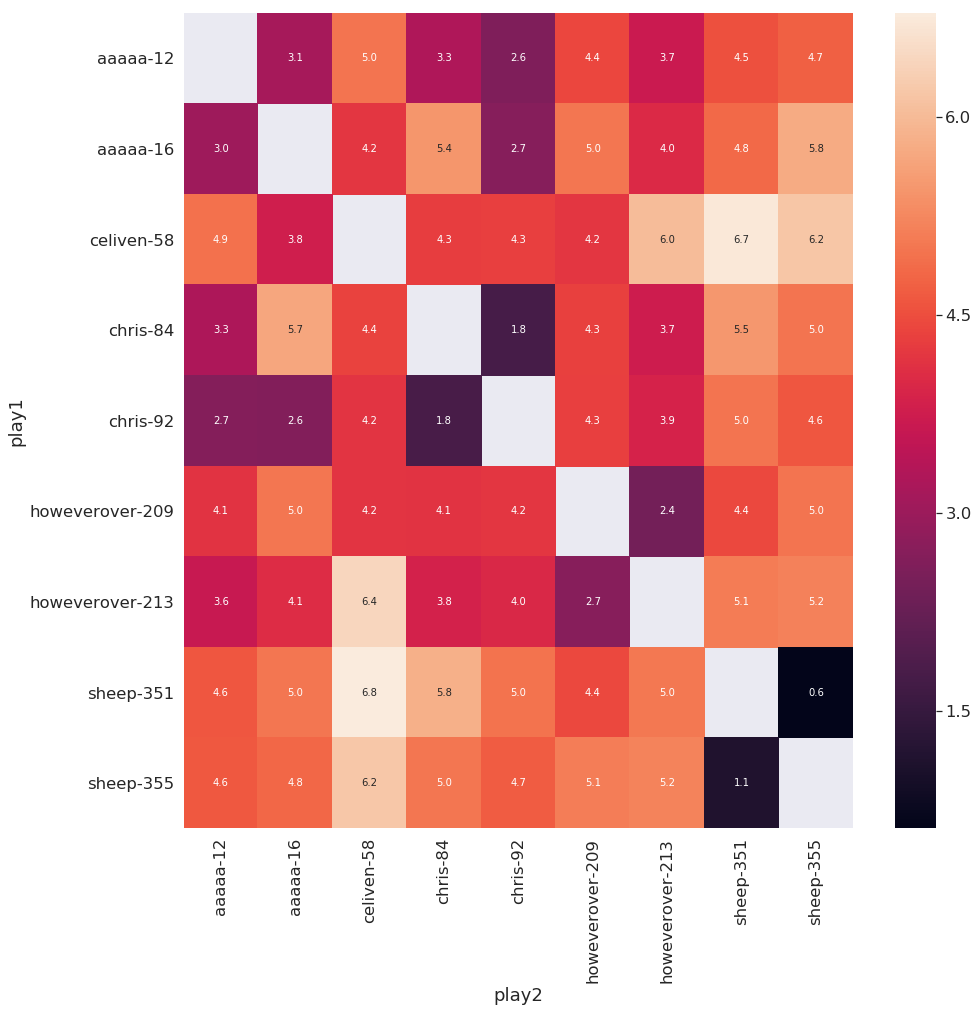

In [15]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(15, 15))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# LGBM

In [16]:
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
score_right_df = play_record_df.copy()
score_right_df = score_right_df[['score', 'id']]

score_df = dtw_df.copy()
score_df = score_df.merge(score_right_df, left_on='a_id', right_on='id', how='inner')
score_df = score_df.merge(score_right_df, left_on='b_id', right_on='id', how='inner')
score_df = score_df[score_df['a_id'] < score_df['b_id']].reset_index(drop=True)
score_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
score_df['score_dif'] = np.abs(score_df['score_x'] - score_df['score_y'])
score_df.drop(['score_x', 'score_y'], axis=1, inplace=True)
score_df

,a_id,b_id,acc_dtw,gyr_dtw,norm_sim,score_dif
0,12,16,3.147988,0.000000,3.147988,3440
1,12,58,4.058228,2.897852,4.986658,49760
2,16,58,3.170941,2.739804,4.190631,53200
3,12,84,2.754627,1.787197,3.283602,27030
4,16,84,4.676980,2.790208,5.446045,30470
5,58,84,3.250329,2.797877,4.288677,22730
6,12,92,2.162282,1.430727,2.592768,11730
7,16,92,2.158345,1.625948,2.702251,15170
8,58,92,3.405479,2.647475,4.313515,38030
9,84,92,1.747496,0.131010,1.752400,15300


In [18]:
train_df = score_df.drop(['a_id', 'b_id'], axis=1).copy()
x = train_df.drop('score_dif', axis=1)
y = train_df['score_dif']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=0, test_size=0.5)

train_df

,acc_dtw,gyr_dtw,norm_sim,score_dif
0,3.147988,0.000000,3.147988,3440
1,4.058228,2.897852,4.986658,49760
2,3.170941,2.739804,4.190631,53200
3,2.754627,1.787197,3.283602,27030
4,4.676980,2.790208,5.446045,30470
5,3.250329,2.797877,4.288677,22730
6,2.162282,1.430727,2.592768,11730
7,2.158345,1.625948,2.702251,15170
8,3.405479,2.647475,4.313515,38030
9,1.747496,0.131010,1.752400,15300


In [19]:
train_set = lgb.Dataset(x_train, y_train)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'application': 'rmse',
#     'min_data_in_leaf': 3,
#     'max_depth': 100,
#     'num_leaves': 2 ** 7,
#     'min_data': 1,
    'verbosity': 0,
#     'metric': ['l2']
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

model = lgb.train(params, train_set=train_set, valid_sets=watchlist,
                  num_boost_round=2000, verbose_eval=20, early_stopping_rounds=100)
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

LightGBMError: Cannot construct Dataset since there are no useful features.
It should be at least two unique rows.
If the num_row (num_data) is small, you can set min_data=1 and min_data_in_bin=1 to fix this.
Otherwise, please make sure you are using the right dataset

In [ ]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'score_dif'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)
plot_df = plot_df.head(30)
plt.figure(figsize=(8, 25))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

In [ ]:
compare_df = pd.DataFrame(data={
    'pred': y_pred,
    'test': y_test,
})
compare_df['dif'] = np.abs(compare_df['pred'] - compare_df['test'])
compare_df.reset_index(inplace=True)
compare_df

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('The mae of prediction is:', mean_absolute_error(y_test, y_pred))
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The mape of prediction is:', mean_absolute_percentage_error(y_test, y_pred))